# Figure 4

The code below has been used to create Figure 4 in [the main paper](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2) as well as Figure S71 and S88-S94 in the [supplement](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2.supplementary-material).

Contact: pawel.szczerbiak@uj.edu.pl or p.szczerbiak@gmail.com

## Setting environment

Before running other cells, run the commands below in the terminal and activate the  `<env_name>` kernel in this notebook:

`conda create -n <env_name> numpy seaborn ipykernel`  
`conda activate <env_name>`  
`ipython kernel install --user --name=<env_name>`

Alternatively, one can use `virtualenv` instead of `conda` package manager.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from pathlib import Path

## Global paths

**NOTE:** change the paths below appropriately.  
The first one should point to the `intermediate_data` folder downloded from the [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs) website.

In [2]:
INTER_DIR = Path('/storage/mip1/protein_universe_paper/data_final/intermediate_data/')
OUT_DIR = Path('./')  # current notebook directory

## Data generation


### DeepFRI predictions

`DeepFRI` predictions (`pkl` files in `function_structures/tmalign/` folder) were extracted from the `DeepFRI`'s `json` files in the `metadata` folder (see [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs) website).

### TM-scores

- For each GO term/EC number: 
    - We found MIP IDs (separetely for Rosetta curated and DMPFold curated datasets) that were annotated by `DeepFRI` with `score >= 0.2` (see `function_structures/tmalign/input` folder).
    - Next, we computed pairwise structural similarity among such MIP structures (see `function_structures/tmalign/output` folder). Due to limited resources, we considered only those GO terms/EC numbers with up to 1000 annotated structures.

## Load data

### Load GO term / EC number descriptions

In [3]:
gogroups = ["BP", "CC", "MF", "EC"]
go_txt = {}
for key in gogroups:
    go_txt[key] = pd.read_csv(INTER_DIR / 'function_structures' / 'goterms' / f'go_txt_{key}.csv', index_col=0)

### Load function predictions

**NOTE:** `DeepFRI` predictions weigh ~20 GB

In [4]:
preds_all_ros = {}
preds_all_dmp = {}
for key in gogroups:
    print(f'Loading {key}...')
    preds_all_ros[key] = pickle.load(open(INTER_DIR / 'function_structures' / 'deepfri' / f'curated_rosetta_{key}.pkl', 'rb'))
    preds_all_dmp[key] = pickle.load(open(INTER_DIR / 'function_structures' / 'deepfri' / f'curated_dmpfold_{key}.pkl', 'rb'))    

Loading BP...
Loading CC...
Loading MF...
Loading EC...


### Load GO term / EC number lists sorted by decreasing information content (IC)

In [5]:
high_score_sorted_dmp = {}
high_score_sorted_ros = {}
for key in gogroups:
    high_score_sorted_dmp[key] = pd.read_csv(open(INTER_DIR / 'function_structures' / 'tmalign' / 'input' / f'dmpfold_{key}.csv'), index_col=0)
    high_score_sorted_ros[key] = pd.read_csv(open(INTER_DIR / 'function_structures' / 'tmalign' / 'input' / f'rosetta_{key}.csv'), index_col=0)

## Load TM-scores

**NOTE:** `TMalign` predictions weigh ~2.4 GB but due to number of files their loading may take several minutes

In [6]:
def load_tmscores(method, gogroups=gogroups):
    tmscores, tmscores_max = {}, {}
    for key in gogroups:
        path = INTER_DIR / 'function_structures' / 'tmalign' / 'output' / method / key
        print(f'{method}, loading {key}...')
        tmscores[key] = {}
        tmscores_max[key] = {}
        # TM-scores normalized by average length
        for file in (path).glob('*/tmscores.tsv'):
            idx = int(file.parent.name)
            tmscores[key][idx] = np.loadtxt(file)
        # Max between TM-score normalized by length 1 and length 2
        for file in (path).glob('*/tmscores_max.tsv'):
            idx = int(file.parent.name)
            res = np.loadtxt(file)
            # Hack: for each row, take max of two columns
            if len(res) > 2:
                tmscores_max[key][idx] = res.max(axis=1)
            else:
                tmscores_max[key][idx] = np.array([res.max()])
    return tmscores, tmscores_max

In [7]:
tmscores_ros, tmscores_max_ros = load_tmscores('rosetta')
tmscores_dmp, tmscores_max_dmp = load_tmscores('dmpfold')

rosetta, loading BP...
rosetta, loading CC...
rosetta, loading MF...
rosetta, loading EC...
dmpfold, loading BP...
dmpfold, loading CC...
dmpfold, loading MF...
dmpfold, loading EC...


## Compute mean/std TM-scores for a given GO-term

In [8]:
# TM-scores normalized by average length
tmscore_cols = ['TMscore mean', 'TMscore std', 'TMscore comparisons']
for key in gogroups:
    high_score_sorted_ros[key][tmscore_cols] = np.nan
    for idx, scores in tmscores_ros[key].items():
        high_score_sorted_ros[key].loc[high_score_sorted_ros[key]['index'] == int(idx), tmscore_cols] = \
        [scores.mean(), scores.std(), scores.size]  
    high_score_sorted_dmp[key][tmscore_cols] = np.nan
    for idx, scores in tmscores_dmp[key].items():
        high_score_sorted_dmp[key].loc[high_score_sorted_dmp[key]['index'] == int(idx), tmscore_cols] = \
        [scores.mean(), scores.std(), scores.size]  
# Max between TM-score normalized by length 1 and length 2
tmscore_max_cols = ['Max TMscore mean', 'Max TMscore std', 'Max TMscore comparisons']
for key in gogroups:
    high_score_sorted_ros[key][tmscore_max_cols] = np.nan
    for idx, scores in tmscores_max_ros[key].items():
        high_score_sorted_ros[key].loc[high_score_sorted_ros[key]['index'] == int(idx), tmscore_max_cols] = \
        [scores.mean(), scores.std(), scores.size]  
    high_score_sorted_dmp[key][tmscore_max_cols] = np.nan
    for idx, scores in tmscores_max_dmp[key].items():
        high_score_sorted_dmp[key].loc[high_score_sorted_dmp[key]['index'] == int(idx), tmscore_max_cols] = \
        [scores.mean(), scores.std(), scores.size]  

### Check if number of comparisons match number of initial MIP IDs

In [9]:
for key in gogroups:
    # Rosetta
    df1 = high_score_sorted_ros[key][high_score_sorted_ros[key][tmscore_cols[0]].notna()]
    df2 = high_score_sorted_ros[key][high_score_sorted_ros[key][tmscore_max_cols[0]].notna()]
    assert (df1['Number'] * (df1['Number'] - 1) / 2 == df1['TMscore comparisons']).all()
    assert (df2['Number'] * (df2['Number'] - 1) / 2 == df2['Max TMscore comparisons']).all()
    assert (df1.index == df2.index).all()
    # DMPFold
    df1 = high_score_sorted_dmp[key][high_score_sorted_dmp[key][tmscore_cols[0]].notna()]
    df2 = high_score_sorted_dmp[key][high_score_sorted_dmp[key][tmscore_max_cols[0]].notna()]
    assert (df1['Number'] * (df1['Number'] - 1) / 2 == df1['TMscore comparisons']).all()   
    assert (df2['Number'] * (df2['Number'] - 1) / 2 == df2['Max TMscore comparisons']).all()   
    assert (df1.index == df2.index).all()

## Plots

### Helper functions

In [10]:
def cap_first(_str):
    """Capitalize first letter"""
    return _str[0].upper() + _str[1:]

In [11]:
def get_heatmap_scores(key, ind, method, max_tmscore=True):
    """Generate TM-score matrix.
       See `get_heatmaps` function below for details.
    """
    with open(INTER_DIR / 'function_structures' / 'tmalign' / 'input' / method / key / f'{ind}.txt', 'r') as f:
        lines = f.read().splitlines()
    tmscores = np.zeros([len(lines), len(lines)])
    for i, mip in enumerate(lines[:-1]):
        file = INTER_DIR / 'function_structures' / 'tmalign' / 'output' / method / key / str(ind) / f'{mip}.tsv'
        if max_tmscore:
            tmp = pd.read_csv(file, header=None, sep='\t')[[6, 7]].max(axis=1).values
        else:
            tmp = pd.read_csv(file, header=None, sep='\t')[8].values
        tmscores[i, i+1:] = tmp
    tmscores = tmscores + tmscores.T
    np.fill_diagonal(tmscores, 1)
    return lines, tmscores

In [12]:
def get_heatmap(lines, tmscores, method, key, goterm, sparse_labels, save, max_tmscore=True):
    """Generate heatmap for selected method.
       See `get_heatmaps` function below for details.
    """
    colors = sns.color_palette('plasma', 7)
    levels = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    kwargs = {} if sparse_labels else {'xticklabels': 1, 'yticklabels': 1}
    cmap, norm = mpl.colors.from_levels_and_colors(levels, colors, extend="both")
    ax = sns.clustermap(tmscores, figsize=(7, 7), cmap = cmap, norm=norm, 
                            cbar_kws={'spacing': "proportional"}, **kwargs)
    if sparse_labels: 
        ticks = dict(zip(range(len(lines)), lines))
        order = [int(el.get_text()) for el in ax.ax_heatmap.get_xticklabels()]
        ax.ax_heatmap.set_yticks(ax.ax_heatmap.get_xticks())
        ax.ax_heatmap.set_xticklabels([ticks[el] for el in order], size=10, rotation=45, ha='right')
        ax.ax_heatmap.set_yticklabels([ticks[el] for el in order], size=10, rotation=0)
    else:
        order = np.array(ax.dendrogram_row.reordered_ind)
        ax.ax_heatmap.set_xticklabels(np.array(lines)[order], size=11, rotation=45, ha='right')
        ax.ax_heatmap.set_yticklabels(np.array(lines)[order], size=11, rotation=0)
    title = go_txt[key].loc[goterm]['Names']
    ax.ax_col_dendrogram.set_title(f"{method}: {cap_first(title)}", fontsize=16)
    if save:
        plt.savefig(OUT_DIR / f'{key}_{goterm}_{method}.png', bbox_inches = 'tight', dpi=400)

In [13]:
def get_heatmaps(key, goterm, sparse_labels, save=False, max_tmscore=True):
    """Generate heatmaps.
       Notes: 
       - If 'max_tmscore=True', use max TM-score as an input.
         Otherwise, use TM-score normalized by length 1 and length 2.
       - If 'sparse_labels=True', show only every 10th label on x and y axis.
    """
    ind = int(high_score_sorted_ros[key].loc[goterm]['index'])
    lines_ros, tmscores_ros = get_heatmap_scores(key, ind, 'rosetta', max_tmscore)
    lines_dmp, tmscores_dmp = get_heatmap_scores(key, ind, 'dmpfold', max_tmscore) 
    get_heatmap(lines_ros, tmscores_ros, 'Rosetta', key, goterm, sparse_labels, save, max_tmscore=True)
    get_heatmap(lines_dmp, tmscores_dmp, 'DMPFold', key, goterm, sparse_labels, save, max_tmscore=True)
    plt.show()

### Generate heatmaps for interesting GO terms / EC numbers

Use `save=True` below to save figures.

In [14]:
goterms = [
           # main paper
           ('MF', 'GO:0030246', True),
           ('BP', 'GO:0043571', False),  
           ('EC', '4.99.1.-', False), 
           # # supplement
           ('BP', 'GO:0030683', False),  
           ('EC', '2.7.10.-', True),
           ('EC', '4.2.1.1', False), 
           ('EC', '2.7.1.21', False),
           ('MF',  'GO:0005125', False), 
           ('MF', 'GO:0009881', True), 
           ('MF',  'GO:0004930', True), 
]

MF GO:0030246


/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


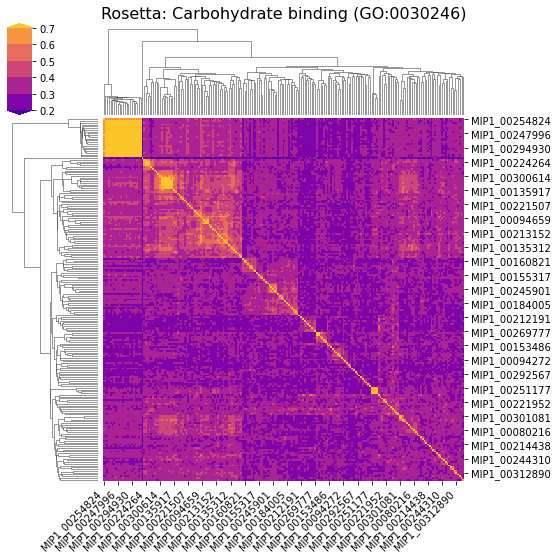

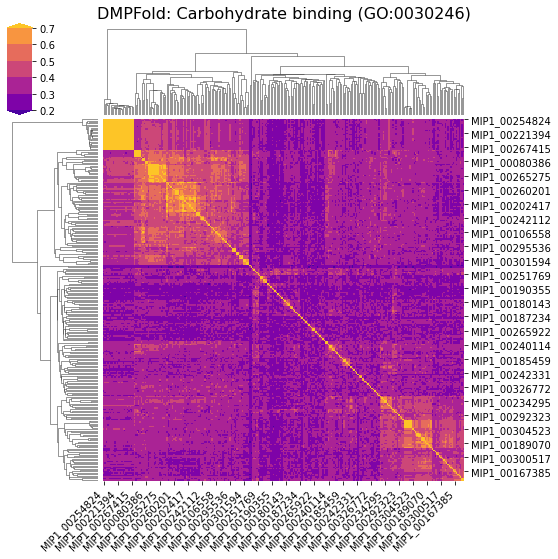

BP GO:0043571


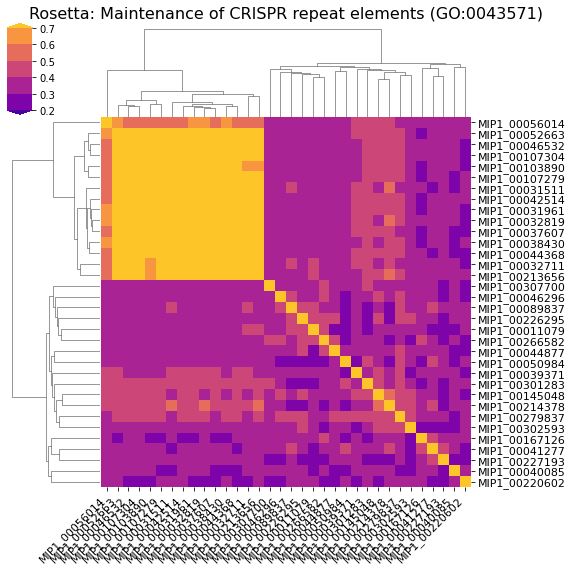

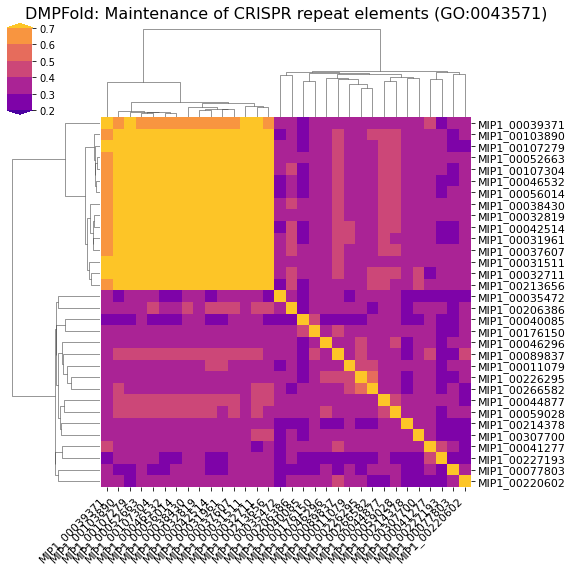

EC 4.99.1.-


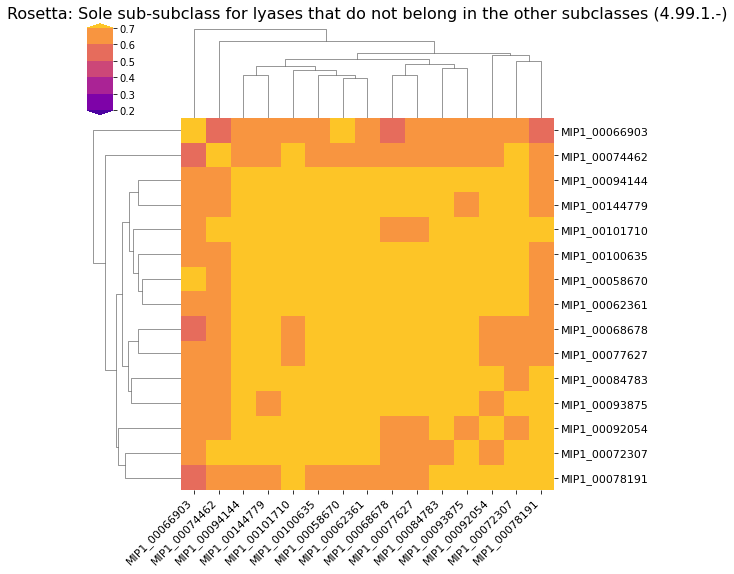

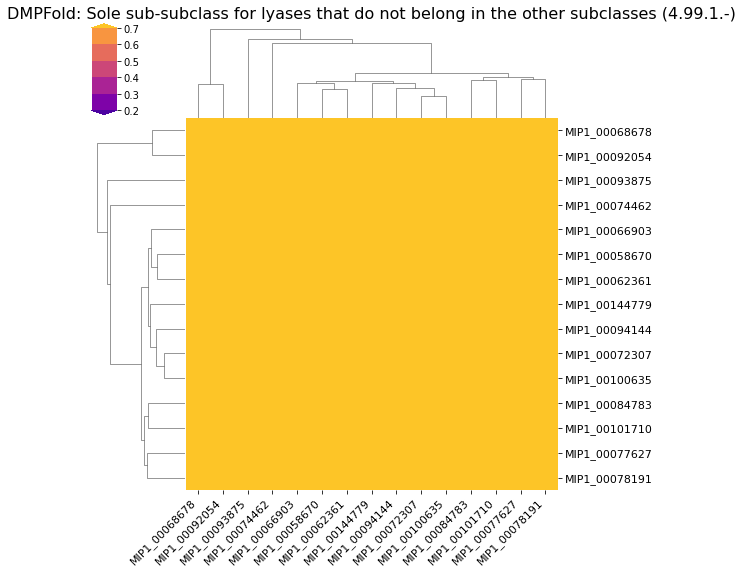

BP GO:0030683


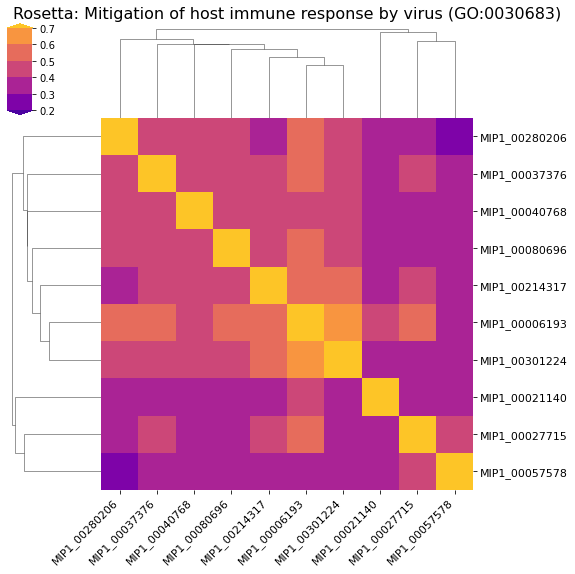

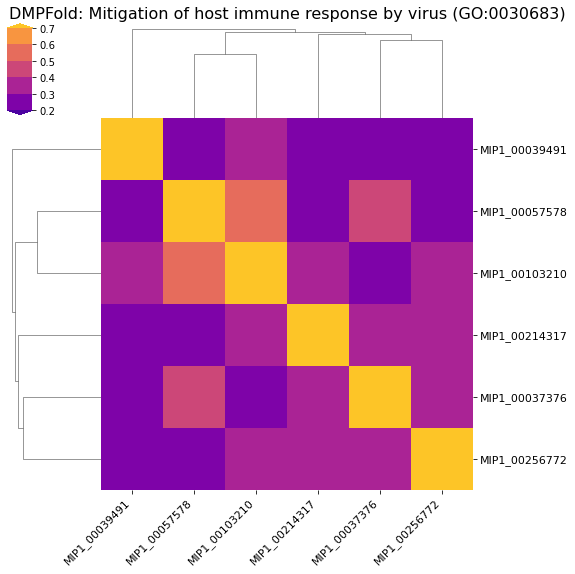

EC 2.7.10.-


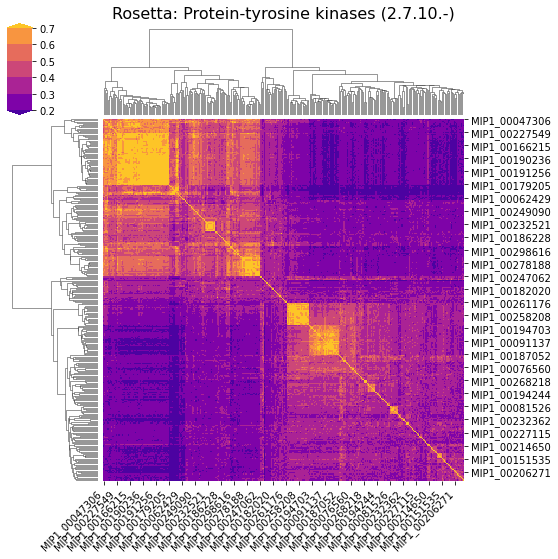

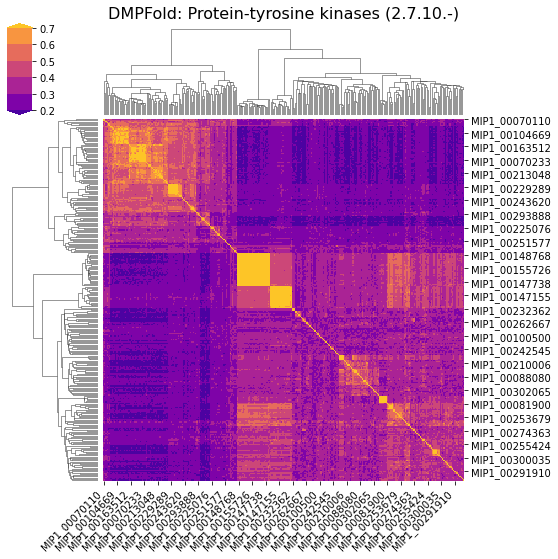

EC 4.2.1.1


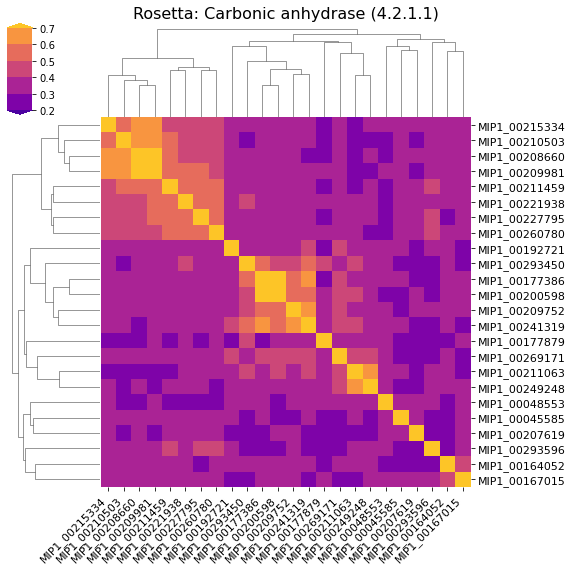

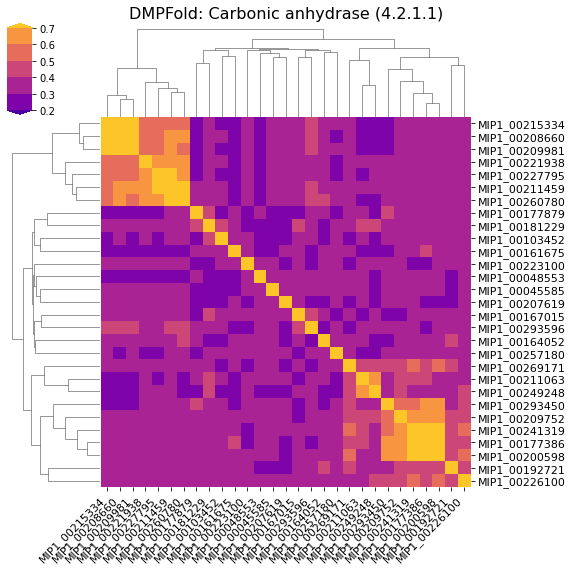

EC 2.7.1.21


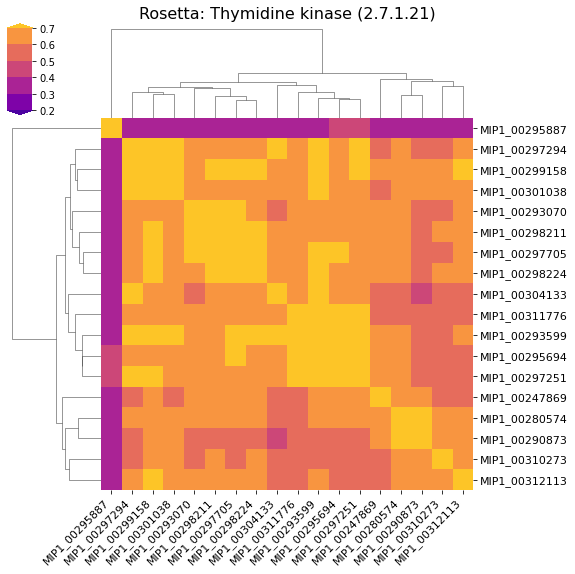

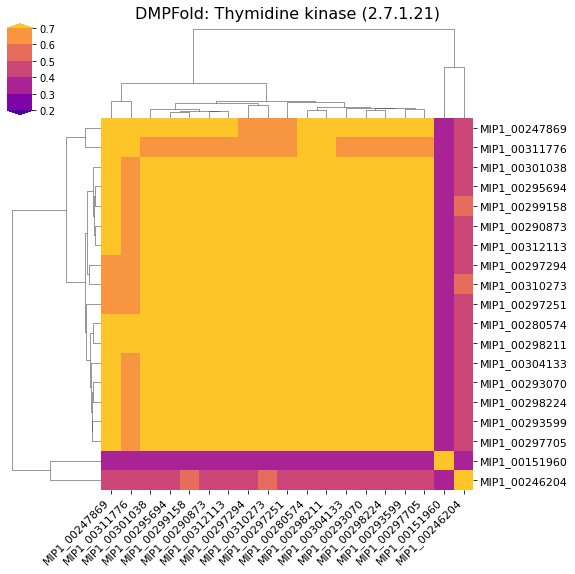

MF GO:0005125


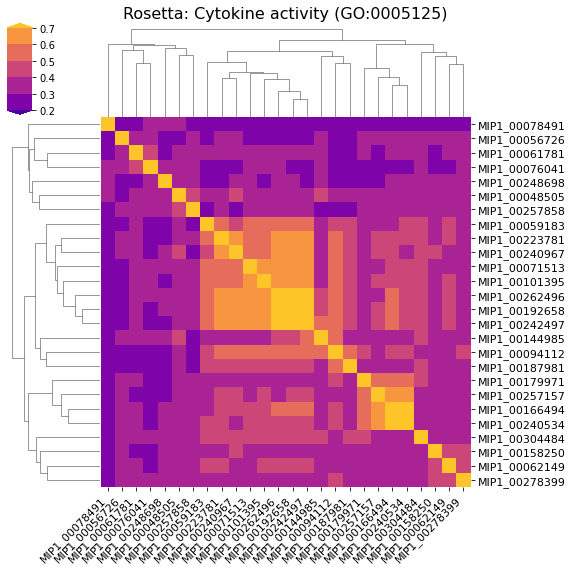

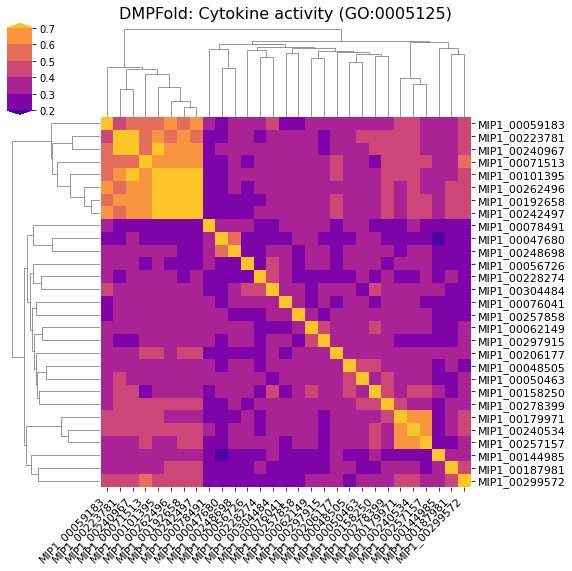

MF GO:0009881


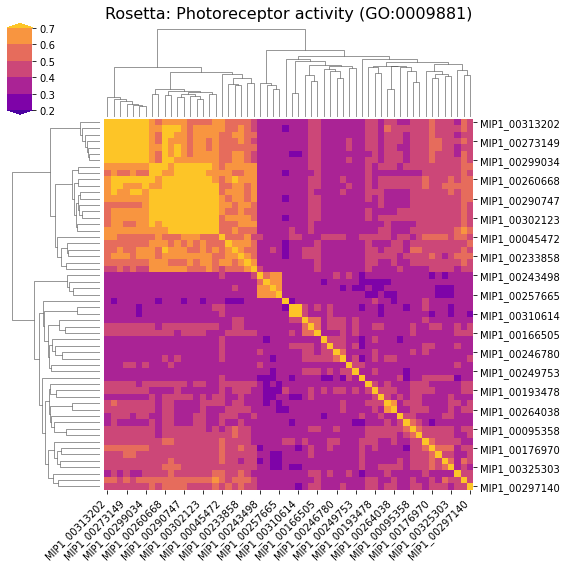

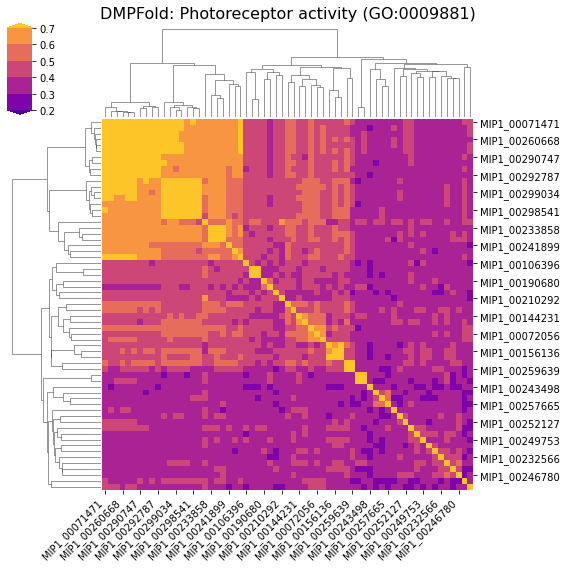

MF GO:0004930


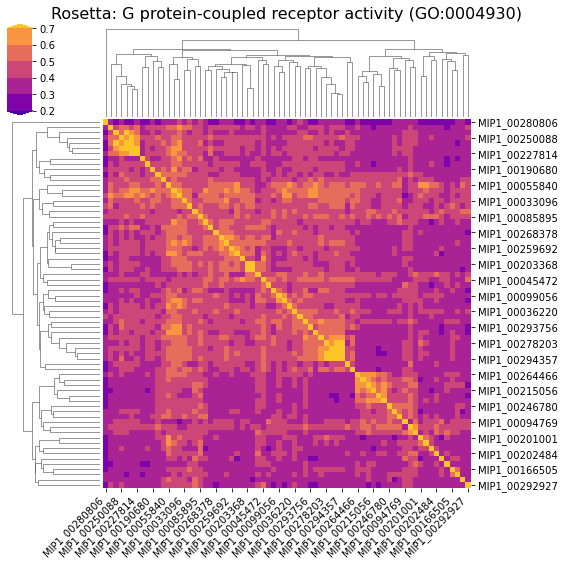

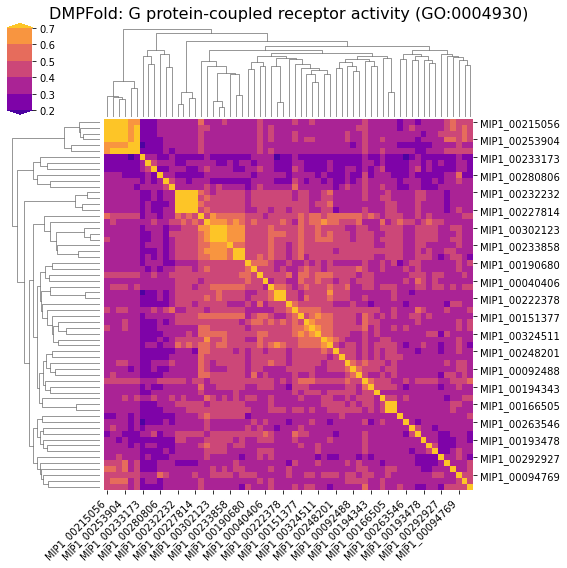

In [15]:
for key, goterm, sparse_labels in goterms:
    print(key, goterm)
    get_heatmaps(key, goterm, sparse_labels, save=False)

## Figure S71

### Minimum / maximum number of comparisons to be included on the plot

In [16]:
min_number = 50
min_comps = int(min_number * (min_number-1) / 2.)
max_number = 1000
max_comps = int(max_number * (max_number-1) / 2.)

### Compute number of GO-terms in each IC bin

In [17]:
ic_bins = [0, 5, 6, 7, 9, 12]

In [18]:
no_comps_ros = {}
no_comps_dmp = {}
for key in ['BP', 'MF', 'CC']:  # We don't have IC for EC group
    # Rosetta
    df = high_score_sorted_ros[key][high_score_sorted_ros[key][tmscore_cols[0]].notna()]
    df = df[(df['TMscore comparisons']>=min_comps) & (df['TMscore comparisons']<=max_comps)]
    df['IC bin'] = pd.cut(df['IC'], ic_bins)
    no_comps_ros[key] = df.groupby('IC bin').agg({'TMscore comparisons': 'sum', 'Number': 'count'})
    # DMPFold
    df = high_score_sorted_dmp[key][high_score_sorted_dmp[key][tmscore_cols[0]].notna()]
    df = df[(df['TMscore comparisons']>=min_comps) & (df['TMscore comparisons']<=max_comps)]
    df['IC bin'] = pd.cut(df['IC'], ic_bins)
    no_comps_dmp[key] = df.groupby('IC bin').agg({'TMscore comparisons': 'sum', 'Number': 'count'})

### Generate plot

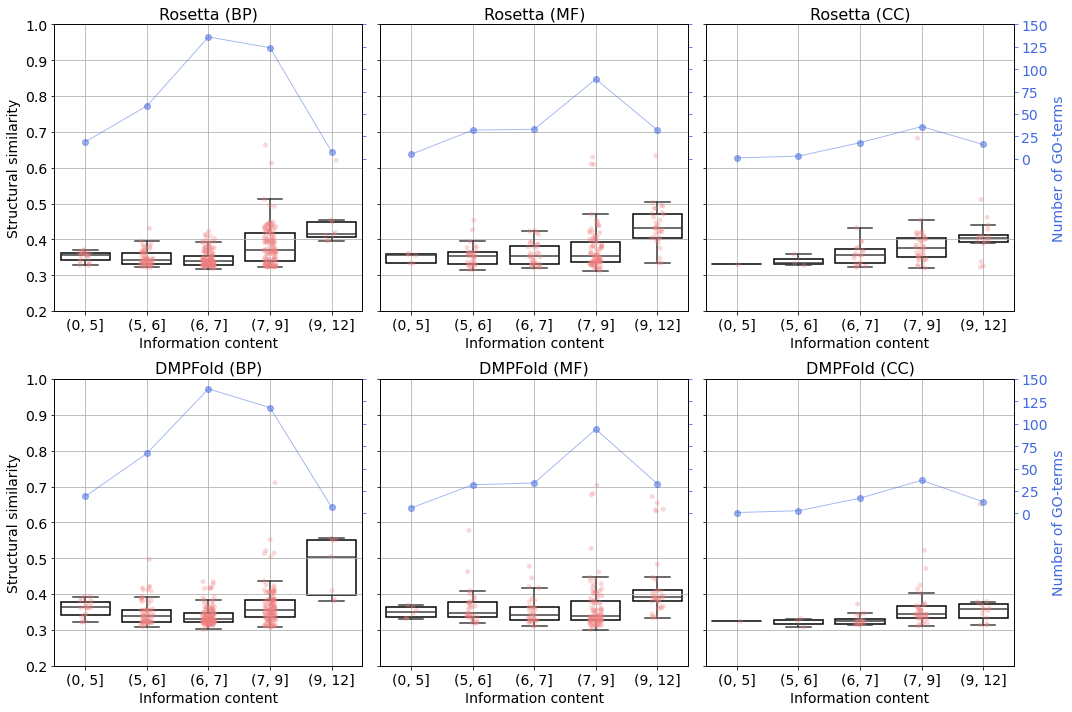

In [20]:
plt.figure(figsize=(15, 10))
methods = ['Rosetta', 'DMPFold']
dfs = [high_score_sorted_ros, high_score_sorted_dmp]
dfs_comps = [no_comps_ros, no_comps_dmp]
kwargs = {'boxprops': {'facecolor': 'w', 'edgecolor': 'k'}}
ind_noshow1 = [(0, 1), (0, 2), (1, 1), (1, 2)]
ind_noshow2 = [(0, 0), (0, 1), (1, 0), (1, 1)]
for j in range(len(dfs)):
    for i, key in enumerate(['BP', 'MF', 'CC']):
        plt.subplot(2, 3, 3*j+i+1)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title(f'{methods[j]} ({key})', fontsize=16)
        df = dfs[j][key][dfs[j][key][tmscore_cols[0]].notna()]
        df = df[(df['TMscore comparisons']>=min_comps) & (df['TMscore comparisons']<=max_comps)]
        df['IC bin'] = pd.cut(df['IC'], ic_bins)
        ax1 = sns.stripplot(x="IC bin", y="Max TMscore mean", data=df, color="lightcoral", size=5, alpha=0.3)
        ax1 = sns.boxplot(x="IC bin", y="Max TMscore mean", data=df, showfliers=False, **kwargs)
        ax1.set(ylabel='Structural similarity', xlabel='Information content', ylim=[0.2, 1])
        ax1.xaxis.label.set_fontsize(14)
        ax1.yaxis.label.set_fontsize(14)
        ax1.grid(True)
        ax2 = ax1.twinx()
        ax2.set(ylabel='Number of GO-terms', yscale='linear', ylim=[-170, 150], yticks=[0, 25, 50, 75, 100, 125, 150])
        ax2.yaxis.label.set_color('royalblue')
        ax2.tick_params(axis='y', colors='royalblue', labelsize=14)
        ax2.plot(ax1.get_xticks(), dfs_comps[j][key]['Number'], '-o', color='royalblue', alpha=0.5, linewidth=0.9)
        ax2.yaxis.label.set_fontsize(14)
        if (j, i) in ind_noshow1:
            ax1.axes.set_ylabel('')
            ax1.axes.set_yticklabels('')
        if (j, i) in ind_noshow2:
            ax2.axes.set_ylabel('')
            ax2.axes.set_yticklabels('')
plt.tight_layout()
plt.show()